Петухова Ксения БКЛ182

In [1]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-27 23:35:36--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-27 23:35:36--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-11-27 23:35:36 ERROR 404: Not Found.

--2021-11-27 23:35:36--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-27 23:35:36--  https:

In [2]:
!pip3 install torchmetrics

     |████████████████████████████████| 329 kB 5.3 MB/s 


In [3]:
!pip3 install ipdb

     |████████████████████████████████| 791 kB 5.3 MB/s 
     |████████████████████████████████| 374 kB 45.4 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=0b100d77f21d7ab7673b7a06f325489da513f74a6c95c5a346a5d840f9e5f4bb
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [4]:
!pip3 install pymorphy2

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 8.2 MB 7.7 MB/s 


In [5]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
import nltk
from string import punctuation
from tqdm import tqdm
import gensim
import matplotlib.pyplot as plt

In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8',
                         sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

FileNotFoundError: ignored

In [ ]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [ ]:
### сайт с датасетом упал, поэтому теперь так:

In [7]:
pos_tweets = pd.read_csv('/content/drive/MyDrive/positive.csv', encoding='utf-8',
                         sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [8]:
neg_tweets = pd.read_csv('/content/drive/MyDrive/negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [9]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [10]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [11]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return ' '.join(tokens)

In [12]:
texts = list(tweets_data.text)
preprocessed_texts = [preprocess(text) for text in tqdm(texts)]
tweets_data['preprocessed_text'] = preprocessed_texts


100%|██████████| 100000/100000 [00:00<00:00, 146653.11it/s]


In [13]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [14]:
train_sentences[:10]

,text,tone,preprocessed_text
62759,#нагризлучшая #голос обидно за второе место :(...,0,нагризлучшая голос обидно за второе место поб...
61077,сегодня я буду 4 часа пыриться на концерты и к...,1,сегодня я буду 4 часа пыриться на концерты и к...
82338,То что нужно после пар))) #goodys #like #minsk...,1,то что нужно после пар goodys like minsk heine...
58794,"Хоспади, какой же всё-таки неудобный новый инт...",0,хоспади какой же всё-таки неудобный новый инте...
14268,"@ichcc @rozhkovsky ну да, я с родителями за ко...",1,ichcc rozhkovsky ну да я с родителями за компанию
34900,"Сегодня специально оделась так,чтобы было прох...",0,"сегодня специально оделась так,чтобы было прох..."
29686,Еду на работу покопаться в сервере и wi-fi точ...,1,еду на работу покопаться в сервере и wi-fi точ...
71607,@yanochka18_96 хотя я не верю в эту дружбу:DD ...,1,yanochka18_96 хотя я не верю в эту дружбу:dd я...
30810,"Блин лента... Вы меня не любите, даже писать п...",0,блин лента вы меня не любите даже писать перес...
81923,Мои любимые носочки))\nАхаахахх\nЗамерзла http...,1,мои любимые носочки ахаахахх замерзла http://t...


In [15]:
vocab = Counter()

for text in tweets_data['preprocessed_text']:
    vocab.update(text.split(' '))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 202617


In [16]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 32481


In [17]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [18]:
id2word = {i:word for word, i in word2id.items()}

In [19]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### CNN на уровне слов

In [ ]:
class TwitterDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [ ]:
train_dataset = TwitterDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
batch[0].shape

torch.Size([1024, 27])

In [ ]:
[id2word[int(i)] for i in batch[0][0]]

['как',
 'говорил',
 'самый',
 'крутой',
 'чувак',
 'я',
 'самый',
 'больной',
 'в',
 'мире',
 'человек',
 'и',
 'в',
 'этот',
 'раз',
 'я',
 'не',
 'имею',
 'ввиду',
 'на',
 'голову',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [ ]:
batch[1]

tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [ ]:
val_dataset = TwitterDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 27])

In [20]:
%%time
w2v = gensim.models.Word2Vec(preprocessed_texts, size=100, window=5, min_count=1)

CPU times: user 35 s, sys: 493 ms, total: 35.4 s
Wall time: 20 s


In [21]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concatenated = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.bigrams(embedded)
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.trigrams(embedded)
        #batch_size x filter_count3 x seq_len*
        concat_ngrams = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        final_layer = self.concatenated(concat_ngrams)


        pooling_final = final_layer.max(2)[0] 
        logits = self.hidden(pooling_final) 
        logits = self.out(logits)      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        preds = model(texts)  
        loss = criterion(preds, ys)  
        loss.backward() 
        optimizer.step() 
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)



starting Epoch 0
Training...
Train loss: 0.7347741425037384
Train loss: 0.7059568130608761
Train loss: 0.6944504249095916
Train loss: 0.6875377003826312
Train loss: 0.6826833004043216

Evaluating on train...
Val loss: 0.7022149227559566, Val f1: 0.6004847288131714
Val loss: 0.6792925903291414, Val f1: 0.5890041589736938
Val loss: 0.6724821412563324, Val f1: 0.5825263261795044
Val loss: 0.6693035195122904, Val f1: 0.5783787369728088
Val loss: 0.6676760826792035, Val f1: 0.575772225856781

Evaluating on test...
Val loss: 1.325424075126648, Val f1: 1.1345562934875488
Val loss: 0.8829265634218851, Val f1: 0.760692298412323
Val loss: 0.7950083017349243, Val f1: 0.6795694231987
Val loss: 0.7554538079670498, Val f1: 0.6519906520843506
Val loss: 0.7350514729817709, Val f1: 0.6334011554718018

starting Epoch 1
Training...
Train loss: 0.6970260329544544
Train loss: 0.6741145253181458
Train loss: 0.6676842892169952
Train loss: 0.6648557586456413
Train loss: 0.6622964732703709

Evaluating on trai

In [ ]:
print("Loss: ", losses_eval[-1])
print("f1: ", f1s_eval[-1])

Loss:  0.5861365675926209
f1:  tensor(0.7023, device='cuda:0')


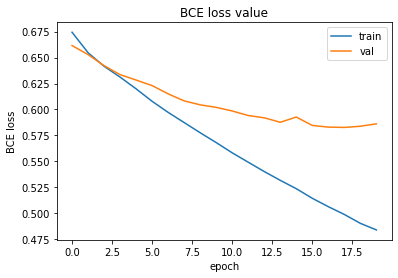

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


модель переобучается на трейне

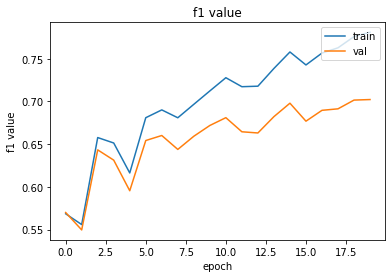

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)

In [ ]:
print('что правильно предсказываем:', tp[:5])

что правильно предсказываем: ['rt с сегодняшнее утро я решила посвятить гитаре и музыку всем замечательного дня', 'ага уроки х и я устала чот спать хотелось жутко х_х', 'три дня отдыха эти выходные просто замечательные', 'деп сол үшін ғой үшін', 'хорошо что мама не посмотрела журнал на собрании хотя на и так все знает а нет d']


In [ ]:
print('ошибочно не относим к негативным:', fn[:5])

ошибочно не относим к негативным: ['это мероприятие проводит мы площадку участников они собирают', 'с  были весь день заняты полезными делами', 'lulkaaa так что не надо тут включать', 'хахха мне всегда было весело:d', 'нет она просто неудобная  я скучаю по старой на которой букв не видно с']


In [45]:
print('ошибочно считаем положительными:', fp[:5])

ошибочно считаем положительными:  ['поехала на почту рабочий день закончился победитель по жизни', 'reedasha ylianatomlinson kevin_real ann_horan69 а до меня наконец дошло что аську', 'женщины  вы самые существа ппц', 'тупые приоритеты у нынешней фотать всё что только и выкладывать в инстаграм особенно фотографироваться в зеркале о_о', 'мама что мы с настей два ножа когда открывали но так и не открыли']


Попробуем добавить в нашу модель еще один пулинг, функцию активации reLU и дропаут

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concatenated = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.bigrams(embedded)
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.trigrams(embedded)
        #batch_size x filter_count3 x seq_len*
        concat_ngrams = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        final_layer = self.dropout(self.pooling(self.relu(self.concatenated(concat_ngrams))))


        pooling_final = final_layer.max(2)[0] 
        logits = self.hidden(pooling_final) 
        logits = self.out(logits)      
        return logits

In [ ]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7471905238926411
Train loss: 0.7139828584410928
Train loss: 0.702025454044342
Train loss: 0.6956649814079057
Train loss: 0.6910913224731173

Evaluating on train...
Val loss: 0.710243221372366, Val f1: 0.6252029538154602
Val loss: 0.6884555292851997, Val f1: 0.6086114048957825
Val loss: 0.6822406351566315, Val f1: 0.6000368595123291
Val loss: 0.6788153408178642, Val f1: 0.5968596339225769
Val loss: 0.6767997543017069, Val f1: 0.5937218070030212

Evaluating on test...
Val loss: 1.3413613438606262, Val f1: 1.12729811668396
Val loss: 0.893420398235321, Val f1: 0.7570306658744812
Val loss: 0.8040358066558838, Val f1: 0.6866993308067322
Val loss: 0.765936051096235, Val f1: 0.6586481928825378
Val loss: 0.7436567544937134, Val f1: 0.6406907439231873

starting Epoch 1
Training...
Train loss: 0.7093343175947666
Train loss: 0.6880765990777449
Train loss: 0.6803259134292603
Train loss: 0.6766210607628325
Train loss: 0.6739321244614465

Evaluating on trai

In [ ]:
print("Loss: ", losses_eval[-1])
print("f1: ", f1s_eval[-1])

Loss:  0.5609992861747741
f1:  tensor(0.7062, device='cuda:0')


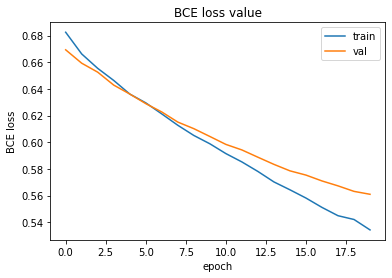

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

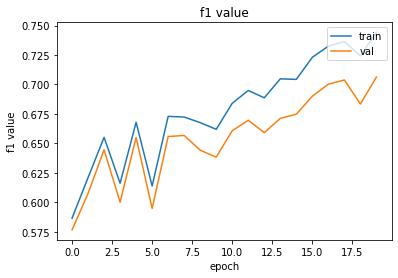

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Как мы видим, модель перестала переобучаться на трейне, f1 мера улучшилась на несколько сотых

### Комбинация эмбеддингов и символьных признаков

In [23]:
vocab_sym = Counter()

for text in tweets_data['preprocessed_text']:
    vocab_sym.update(list(text))
print('всего уникальных символов:', len(vocab_sym))

всего уникальных символов: 294


In [24]:
filtered_vocab_sym = set()

for symbol in vocab_sym:
    if vocab_sym[symbol] > 5:
        filtered_vocab_sym.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_sym))


уникальных символов, втретившихся больше 5 раз: 139


In [25]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab_sym:
    symbol2id[symbol] = len(symbol2id)

In [26]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [30]:
class TwitterDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        ids_sym = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids, ids_sym, y

    def collate_fn(self, batch): 
      ids, ids_sym, y  = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      padded_ids_sym = pad_sequence(ids_sym, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, padded_ids_sym, y

In [31]:
train_dataset = TwitterDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [32]:
batch = next(iter(train_iterator))

In [33]:
val_dataset = TwitterDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [34]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 26])

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, vocab_size_sym, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.embedding_sym = nn.Embedding(vocab_size_sym, embedding_dim)

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')

        self.hidden = nn.Linear(in_features=100, out_features=100)
        self.hidden_sym = nn.Linear(in_features=180, out_features=100)
        self.hidden_final = nn.Linear(in_features=200, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word, sym):
        embedded = self.embedding(word)

        embedded_sent = torch.mean(embedded, dim=1)

        linear_lay = self.hidden(embedded_sent)

        embedded_sym = self.embedding_sym(sym)
        embedded_sym = embedded_sym.transpose(1,2)

        feature_map_bigrams = self.bigrams(embedded_sym)
        feature_map_trigrams = self.trigrams(embedded_sym)
        concat_ngrams = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)


        pooling = concat_ngrams.max(2)[0]
        linear_sym = self.hidden_sym(pooling)


        concat = torch.cat((linear_lay, linear_sym), 1)
        
        logits = self.hidden_final(concat)
        logits = self.out(logits)      
        return logits

In [ ]:
model = CNN(len(word2id), len(symbol2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [27]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, symbols, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        preds = model(texts, symbols)  
        loss = criterion(preds, ys)  
        loss.backward() 
        optimizer.step() 
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.733752179890871
Train loss: 0.7059228998242002
Train loss: 0.6937021410465241
Train loss: 0.6852269919950571
Train loss: 0.6782749550683158

Evaluating on train...
Val loss: 0.6895610503852367, Val f1: 0.6328274011611938
Val loss: 0.6666343808174133, Val f1: 0.6121730804443359
Val loss: 0.659312025308609, Val f1: 0.6057159900665283
Val loss: 0.6564290372293387, Val f1: 0.600706934928894
Val loss: 0.6540357172489166, Val f1: 0.600382924079895

Evaluating on test...
Val loss: 1.2746126651763916, Val f1: 1.2393996715545654
Val loss: 0.8562382062276205, Val f1: 0.8123142123222351
Val loss: 0.7736100077629089, Val f1: 0.7241352200508118
Val loss: 0.7380890931401934, Val f1: 0.6848635673522949
Val loss: 0.7180861102210151, Val f1: 0.6619582772254944

starting Epoch 1
Training...
Train loss: 0.681204441934824
Train loss: 0.657556156317393
Train loss: 0.6459033811092376
Train loss: 0.6391550569391963
Train loss: 0.6334273332641238

Evaluating on trai

In [ ]:
print("Loss: ", losses_eval[-1])
print("f1: ", f1s_eval[-1])

Loss:  0.4964480310678482
f1:  tensor(0.7602)


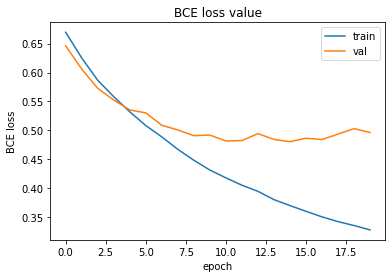

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

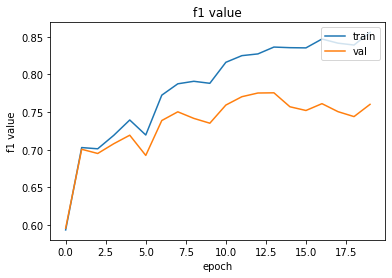

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Попробуем добавить в нашу модель еще один пулинг, функцию активации reLU и дропаут

In [29]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, vocab_size_sym, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.embedding_sym = nn.Embedding(vocab_size_sym, embedding_dim)

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        self.hidden = nn.Linear(in_features=100, out_features=100)
        self.hidden_sym = nn.Linear(in_features=180, out_features=100)
        self.hidden_final = nn.Linear(in_features=200, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word, sym):
        embedded = self.embedding(word)

        embedded_sent = torch.mean(embedded, dim=1)

        linear_lay = self.hidden(embedded_sent)

        embedded_sym = self.embedding_sym(sym)
        embedded_sym = embedded_sym.transpose(1,2)

        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_sym))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_sym))))
        concat_ngrams = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)


        pooling = concat_ngrams.max(2)[0]
        linear_sym = self.hidden_sym(pooling)


        concat = torch.cat((linear_lay, linear_sym), 1)
        
        logits = self.hidden_final(concat)
        logits = self.out(logits)      
        return logits

In [ ]:
model = CNN(len(word2id), len(symbol2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7482596412301064
Train loss: 0.714286435734142
Train loss: 0.7013940274715423
Train loss: 0.6928700093013137
Train loss: 0.686528293859391

Evaluating on train...
Val loss: 0.7082443721592426, Val f1: 0.6006394624710083
Val loss: 0.6877013101722255, Val f1: 0.5767652988433838
Val loss: 0.6808474433422088, Val f1: 0.5696582198143005
Val loss: 0.6775960975618505, Val f1: 0.5651649236679077
Val loss: 0.6756237198909124, Val f1: 0.5631484985351562

Evaluating on test...
Val loss: 1.3315457701683044, Val f1: 1.1448811292648315
Val loss: 0.8901570836702982, Val f1: 0.7576505541801453
Val loss: 0.801436722278595, Val f1: 0.6722220182418823
Val loss: 0.7633493031774249, Val f1: 0.6391071081161499
Val loss: 0.7420355081558228, Val f1: 0.6207618713378906

starting Epoch 1
Training...
Train loss: 0.700221698731184
Train loss: 0.6754381981762972
Train loss: 0.6656170642375946
Train loss: 0.659931085002956
Train loss: 0.6564695480323973

Evaluating on tra

In [ ]:
print("Loss: ", losses_eval[-1])
print("f1: ", f1s_eval[-1])

Loss:  0.5668836116790772
f1:  tensor(0.6918)


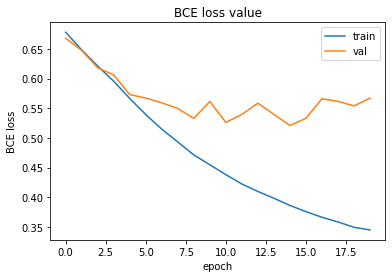

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

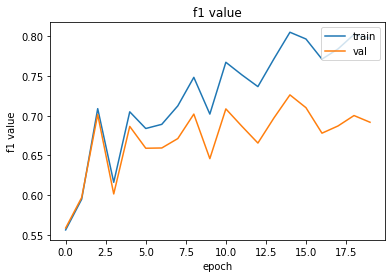

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Как мы видим, качество работы модели ухудшилось, поэтому попробуем сделать что-нибудь еще. Можно, например, покрутить гиперпараметры

In [42]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            # if not (i + 1) % int(len(iterator)/5):
              # print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [46]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
  model = CNN(len(word2id), len(symbol2id), i)
  optimizer = optim.Adam(model.parameters(), lr=0.0005)
  criterion = nn.BCELoss()  

  # веса модели и значения лосса храним там же, где и все остальные тензоры
  model = model.to(DEVICE)
  criterion = criterion.to(DEVICE)
  losses = []
  losses_eval = []
  f1s = []
  f1s_eval = []

  for y in range(20):
      print(f'\nstarting Epoch {y}')
      # print('Training...')
      epoch_loss = train(model, train_iterator, optimizer, criterion)
      losses.append(epoch_loss)
      # print('\nEvaluating on train...')
      f1_on_train,_ = evaluate(model, train_iterator, criterion)
      f1s.append(f1_on_train)
      # print('\nEvaluating on test...')
      f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
      losses_eval.append(epoch_loss_on_test)
      f1s_eval.append(f1_on_test)
      print('embedding_dim = ', i, '; f1 = ', f1_on_test, '; loss = ', epoch_loss_on_test)


starting Epoch 0
Train loss: 0.7524196729063988
Train loss: 0.7195435094110894
Train loss: 0.7057993733882904
Train loss: 0.6962288306720221
Train loss: 0.6886791402385348
embedding_dim =  10 ; f1 =  tensor(0.5297, device='cuda:0') ; loss =  0.6647065699100494

starting Epoch 1
Train loss: 0.6920825950801373
Train loss: 0.6695371667544047
Train loss: 0.6591951358318329
Train loss: 0.6518963139448593
Train loss: 0.6469437863145556
embedding_dim =  10 ; f1 =  tensor(0.6151, device='cuda:0') ; loss =  0.6334054052829743

starting Epoch 2
Train loss: 0.6629443690180779
Train loss: 0.6381992878335895
Train loss: 0.6291533851623535
Train loss: 0.6232151317952285
Train loss: 0.6175318679639271
embedding_dim =  10 ; f1 =  tensor(0.6332, device='cuda:0') ; loss =  0.6085733354091645

starting Epoch 3
Train loss: 0.6266495659947395
Train loss: 0.6062353018558386
Train loss: 0.5984465050697326
Train loss: 0.5931078658175113
Train loss: 0.5883338082404364
embedding_dim =  10 ; f1 =  tensor(0.6607

Так, мы видим, что та же модель, но с размерностью эмбеддинга = 80 работает лучше: f1 = 0.7642, loss =  0.49862594306468966

In [35]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [36]:
model = CNN(len(word2id), len(symbol2id), 80)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for y in range(20):
    print(f'\nstarting Epoch {y}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7371728122234344
Train loss: 0.696884117343209
Train loss: 0.6795744347572327
Train loss: 0.6664916623884173
Train loss: 0.6547542796248481

Evaluating on train...
Val loss: 0.6501341722905636, Val f1: 0.7287598252296448
Val loss: 0.6294470989342892, Val f1: 0.7071633338928223
Val loss: 0.6231754887104034, Val f1: 0.6996847987174988
Val loss: 0.6208362232393293, Val f1: 0.6954509615898132
Val loss: 0.6186558511995134, Val f1: 0.6941967010498047

Evaluating on test...
Val loss: 1.2111101746559143, Val f1: 1.4206953048706055
Val loss: 0.8119651277860006, Val f1: 0.9353048205375671
Val loss: 0.7320349812507629, Val f1: 0.8314833045005798
Val loss: 0.6972817012241909, Val f1: 0.7891724109649658
Val loss: 0.6795224878523085, Val f1: 0.7655028104782104

starting Epoch 1
Training...
Train loss: 0.6327656507492065
Train loss: 0.608149113077106
Train loss: 0.5961474585533142
Train loss: 0.5872222523191082
Train loss: 0.5805157437210992

Evaluating on train...
Val loss: 0.603383790

In [38]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)  # делаем предсказания на тесте 
            for pred, gold, text, sym in zip(preds, ys, texts, symbols):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [39]:
fp, fn, tp, tn = predict(model, val_iterator)

In [40]:
print('что правильно предсказываем: ', tp[:5])

что правильно предсказываем:  ['rt 12 декабря  виктория фестиваль добра', 'то чувство когда понимаешь что твоя презентация самая лучшая наслаждение', 'наконец нормальный выходной с в кафе понеслааась ', 'rt wylsacom запускают angry birds go в один день с gta sa ну удачи горячим парням d', 'с лизой а ты моя кароч игрушка будешь']


In [41]:
print('ошибочно не относим к негативным: ', fn[:5])

ошибочно не относим к негативным:  ['завтра приду в любимых ботинках и смогу забыть эти ужасные сапоги', 'известны результаты олимпиады по району я вторая', 'rt', 'rt открытие нового центра управления в теперь в ', 'во всем надо видеть плюсы я вот например до пятницы могу есть чеснок']


In [43]:
print('ошибочно считаем положительными: ', fp[:5])

ошибочно считаем положительными:  ['перечитываю переписку и сново депресняк', 'мой рисунок фотке не очень получилось webcamtoy', 'нормально поесть естественно некогда работа тв германия берлин …', 'своей с толпы людей с и грустными в', 'reedasha ylianatomlinson kevin_real а до меня наконец дошло что аську']


В обоих случаях:

* модели хорошо справляется в случаях, когда твиты содержат явно положительные эпитеты, напр. "хороший", "замечательный" и т.д.
* если в твитах нет явных негативных слов, то модели часто не считает их негативными
* то же самое происходит с положительными твитами: если в них нет явно положительных слов, то модели могут отнести такие твиты к отрицательным
* есть какие-то слова, инерпретация которых сильно зависит от контекста. Видно, что моделям с такими словами тяжеловато, и отсюда тоже возникают ошибки 